In [169]:
import matplotlib.pyplot as plt
import numpy as numpy
import json
import random
import itertools

In [170]:
training_challenge_dict = json.load(open('../data/RAW_DATA_DIR/arc-prize-2024/arc-agi_training_challenges.json'))
training_solutions_dict = json.load(open('../data/RAW_DATA_DIR/arc-prize-2024/arc-agi_training_solutions.json'))

In [171]:
# find random keys from the training_challenge_dict
random_keys = list(training_challenge_dict.keys())

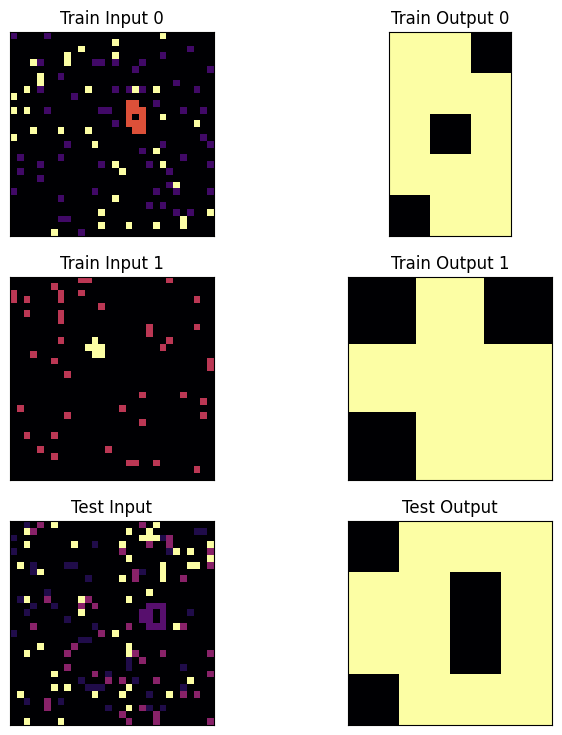

In [172]:
# import the display_challenge function
from utilities.plot import display_challenge

# find the first challenge and solution
challenge_key = '1f85a75f'
first_challenge = training_challenge_dict[challenge_key]
first_solution = training_solutions_dict[challenge_key]

# display the challenge
display_challenge(challenge_key)

In [173]:
import numpy as np

def select_by_color(array, color):
    # mask elements of the array
    mask = array == color
    return mask

def plot_geometries(array, geometries):
    """
    Plot the geometries on the array in different subplots.
    """
    original_array = array.copy()
    num_geometries = len(geometries)
    
    # Calculate the number of rows and columns for the subplots
    num_cols = min(5, num_geometries)  # Max 3 columns
    num_rows = (num_geometries - 1) // num_cols + 1
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))
    axs = axs.flatten() if num_geometries > 1 else [axs]
    
    for idx, geometry in enumerate(geometries):
        i1, j1, i2, j2 = geometry
        new_array = original_array.copy()
        new_array[i1:i2, j1:j2] = 2
        
        axs[idx].imshow(new_array, cmap='inferno')
        axs[idx].set_title(f'Geometry {idx}')
        axs[idx].axis('off')
    
    # Hide any unused subplots
    for idx in range(num_geometries, len(axs)):
        axs[idx].axis('off')
    
    # add a global title
    plt.suptitle('Geometries matching the color')
    plt.show()

def plot_geometry_combinations(array, geometries_combinations, all_geometries):
    """
    Plot the geometry combinations on the array in different subplots.
    """
    original_array = array.copy()
    num_combinations = len(geometries_combinations)
    
    # Calculate the number of rows and columns for the subplots
    num_cols = min(5, num_combinations)  # Max 5 columns
    num_rows = (num_combinations - 1) // num_cols + 1
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))
    axs = axs.flatten() if num_combinations > 1 else [axs]
    
    for idx, geometry_combination in enumerate(geometries_combinations):
        new_array = original_array.copy()
        for j in geometry_combination:
            i1, j1, i2, j2 = all_geometries[j]
            new_array[i1:i2, j1:j2] = 2 + j
        
        axs[idx].imshow(new_array, cmap='inferno')
        axs[idx].set_title(f'Combination {idx+1}')
        axs[idx].axis('off')
    
    # Hide any unused subplots
    for idx in range(num_combinations, len(axs)):
        axs[idx].axis('off')
    
    plt.suptitle('Geometries combinations matching the color')
    plt.show()


def select_by_color_and_geometry(array, target_color, height, width, display=False):
    """
    Select elements of the array with a specific color and geometry.
    Returns all possible non-overlapping combinations of matching geometries.
    """
    color_mask = select_by_color(array, target_color)
    matching_geometries = find_matching_geometries(color_mask, height, width)
    
    if display:
        plot_geometries(array, matching_geometries)

    geometry_combinations = find_non_overlapping_combinations(matching_geometries)

    if display:
        plot_geometry_combinations(array, geometry_combinations, matching_geometries)

    return geometry_combinations

def find_matching_geometries(color_mask, height, width):
    """Find all geometries matching the specified dimensions in the color mask."""
    matching_geometries = []
    rows, cols = np.where(color_mask)
    
    for start_row, start_col in zip(rows, cols):
        end_row, end_col = start_row + height, start_col + width
        
        if is_valid_geometry(color_mask, start_row, start_col, end_row, end_col):
            matching_geometries.append((start_row, start_col, end_row, end_col))
    
    return matching_geometries

def is_valid_geometry(color_mask, start_row, start_col, end_row, end_col):
    """Check if the specified geometry is valid and fully colored."""
    if end_row > color_mask.shape[0] or end_col > color_mask.shape[1]:
        return False
    return np.all(color_mask[start_row:end_row, start_col:end_col])

def find_non_overlapping_combinations(geometries):
    """Find all possible combinations of non-overlapping geometries."""    

    free_array = np.zeros((len(geometries), len(geometries)), dtype=bool)
    for i in range(len(geometries)):
        for j in range(i+1, len(geometries)):
            free_array[i, j] = not geometries_overlap(geometries[i], geometries[j])
    print('overlap_array: \n', free_array)
    overlap_array = np.logical_not(free_array)
    
    
    
    def recursive_combinations_finder(free_array, current_combinations):
        print(f'current combinations: ', current_combinations)
        
        for combination in current_combinations:
            print(f'combination: ', combination)
            combination_list = list(combination)
            free_row = np.prod(free_array[combination_list], axis=0)
            free_row[combination_list] = False
            
            if any(free_row):
                indices_where_true = np.where(free_row)[0]
                print(f'indices where true: ', indices_where_true)
                new_combinations = [combination.copy() for _ in range(len(indices_where_true))]
                for i, index in enumerate(indices_where_true):
                    new_combinations[i].add(int(index))
                #current_combinations.remove(combination)
                print(f'new combinations: ', new_combinations)
                new_combinations = recursive_combinations_finder(free_array, new_combinations)
                current_combinations.extend(new_combinations)
            
        print(f'current combinations: ', current_combinations)
        print('')
        
        return current_combinations

    combinations = recursive_combinations_finder(free_array, [set([i]) for i in range(len(geometries))])
    combinations = set([frozenset(combination) for combination in combinations])
    print(f'combinations: ', combinations)
    """
    combinations = set()
    for i in range(len(geometries)-1, -1, -1):
        combination = set([i])
        for j in range(len(geometries)-1, -1, -1):
            overlap_found = False
            for k in combination:
                if overlap_array[j, k]:
                    overlap_found = True
                    break
            if not overlap_found:
                combination.add(j)
        combinations.add(frozenset(combination))
    combinations = list(combinations)
    
    for p in range(num_permutations): #iterate over all orders of geometries
        new_order = permutation_array[p]
        for i in new_order:
            combination = find_compatible_geometries(geometries, i)
           
            combinations.add(frozenset(combination))
    """
    return list(combinations)

def find_compatible_geometries(geometries, start_index):
    """Find all geometries compatible with the starting geometry."""
    compatible = {start_index}
    start_geometry = geometries[start_index]

    for j, candidate in enumerate(geometries): # iterate over all geometries again
            overlap_found = False
            for k in compatible: # iterate over the indices of the geometries that are already in the combination
                compatible_k = geometries[k] # get the geometry that is already in the combination
                print(f'checking goemetries {j} and {k}')
                if geometries_overlap(candidate, compatible_k): # check if the geometry2 overlaps with the selected geometry
                    overlap_found = True # if there is an overlap, we break
                    print(f'overlap')
                    break
                else:
                    print(f'free')
                print(f'compatible: {compatible}\n')
            if not overlap_found: # if there is no overlap, we add the geometry to the combination
                compatible.add(j)
    
    return compatible

def geometries_overlap(geo1, geo2):
    """Check if two geometries overlap."""
    r1, c1, r1_end, c1_end = geo1
    r2, c2, r2_end, c2_end = geo2
    
    row_overlap = (r1 <= r2 < r1_end) or (r2 <= r1 < r2_end)
    col_overlap = (c1 <= c2 < c1_end) or (c2 <= c1 < c2_end)
    
    return row_overlap and col_overlap

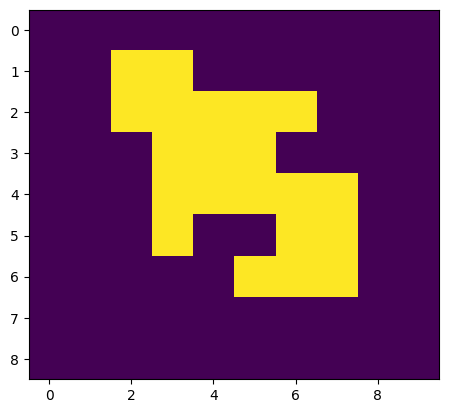

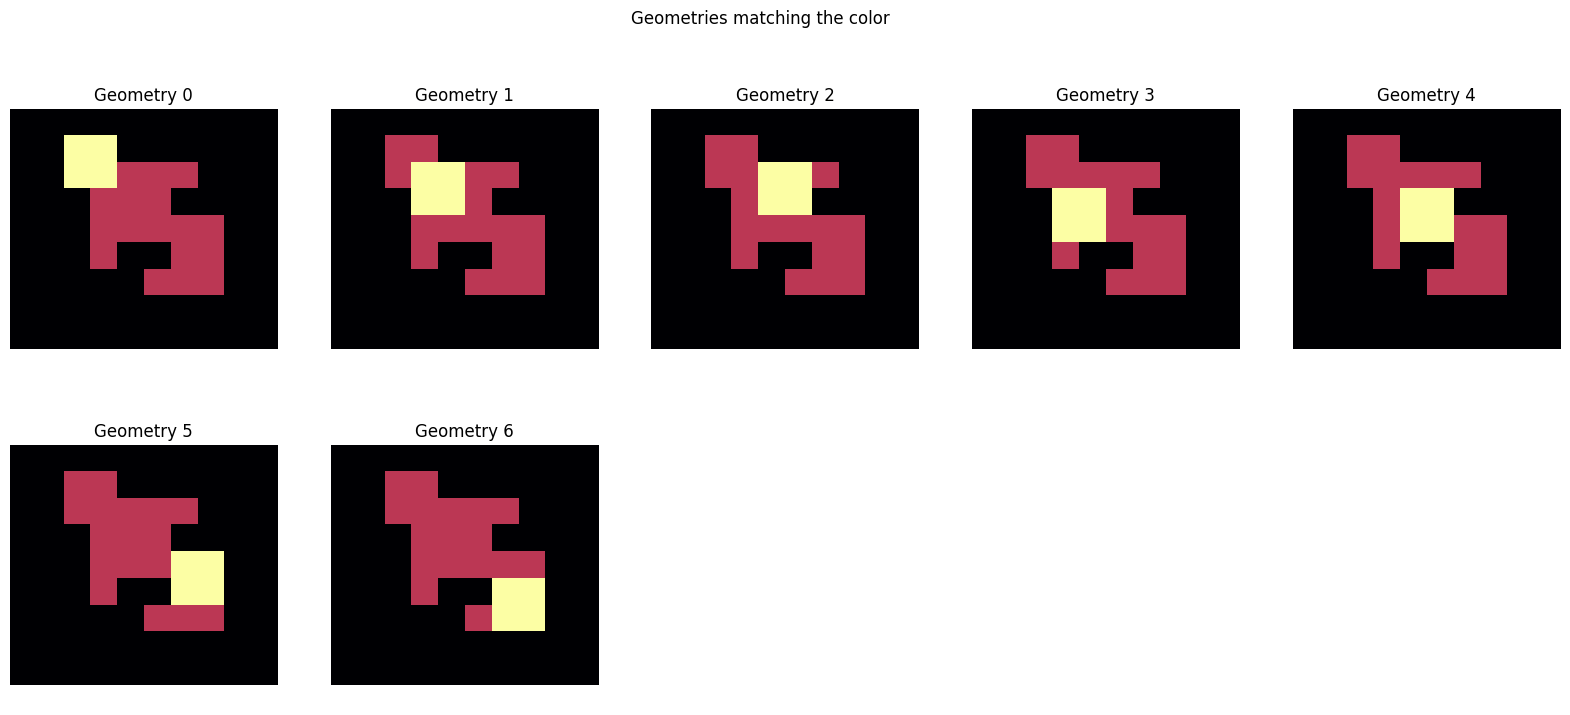

overlap_array: 
 [[False False  True  True  True  True  True]
 [False False False False False  True  True]
 [False False False False False  True  True]
 [False False False False False  True  True]
 [False False False False False  True  True]
 [False False False False False False False]
 [False False False False False False False]]
current combinations:  [{0}, {1}, {2}, {3}, {4}, {5}, {6}]
combination:  {0}
indices where true:  [2 3 4 5 6]
new combinations:  [{0, 2}, {0, 3}, {0, 4}, {0, 5}, {0, 6}]
current combinations:  [{0, 2}, {0, 3}, {0, 4}, {0, 5}, {0, 6}]
combination:  {0, 2}
indices where true:  [5 6]
new combinations:  [{0, 2, 5}, {0, 2, 6}]
current combinations:  [{0, 2, 5}, {0, 2, 6}]
combination:  {0, 2, 5}
combination:  {0, 2, 6}
current combinations:  [{0, 2, 5}, {0, 2, 6}]

combination:  {0, 3}
indices where true:  [5 6]
new combinations:  [{0, 3, 5}, {0, 3, 6}]
current combinations:  [{0, 3, 5}, {0, 3, 6}]
combination:  {0, 3, 5}
combination:  {0, 3, 6}
current combinatio

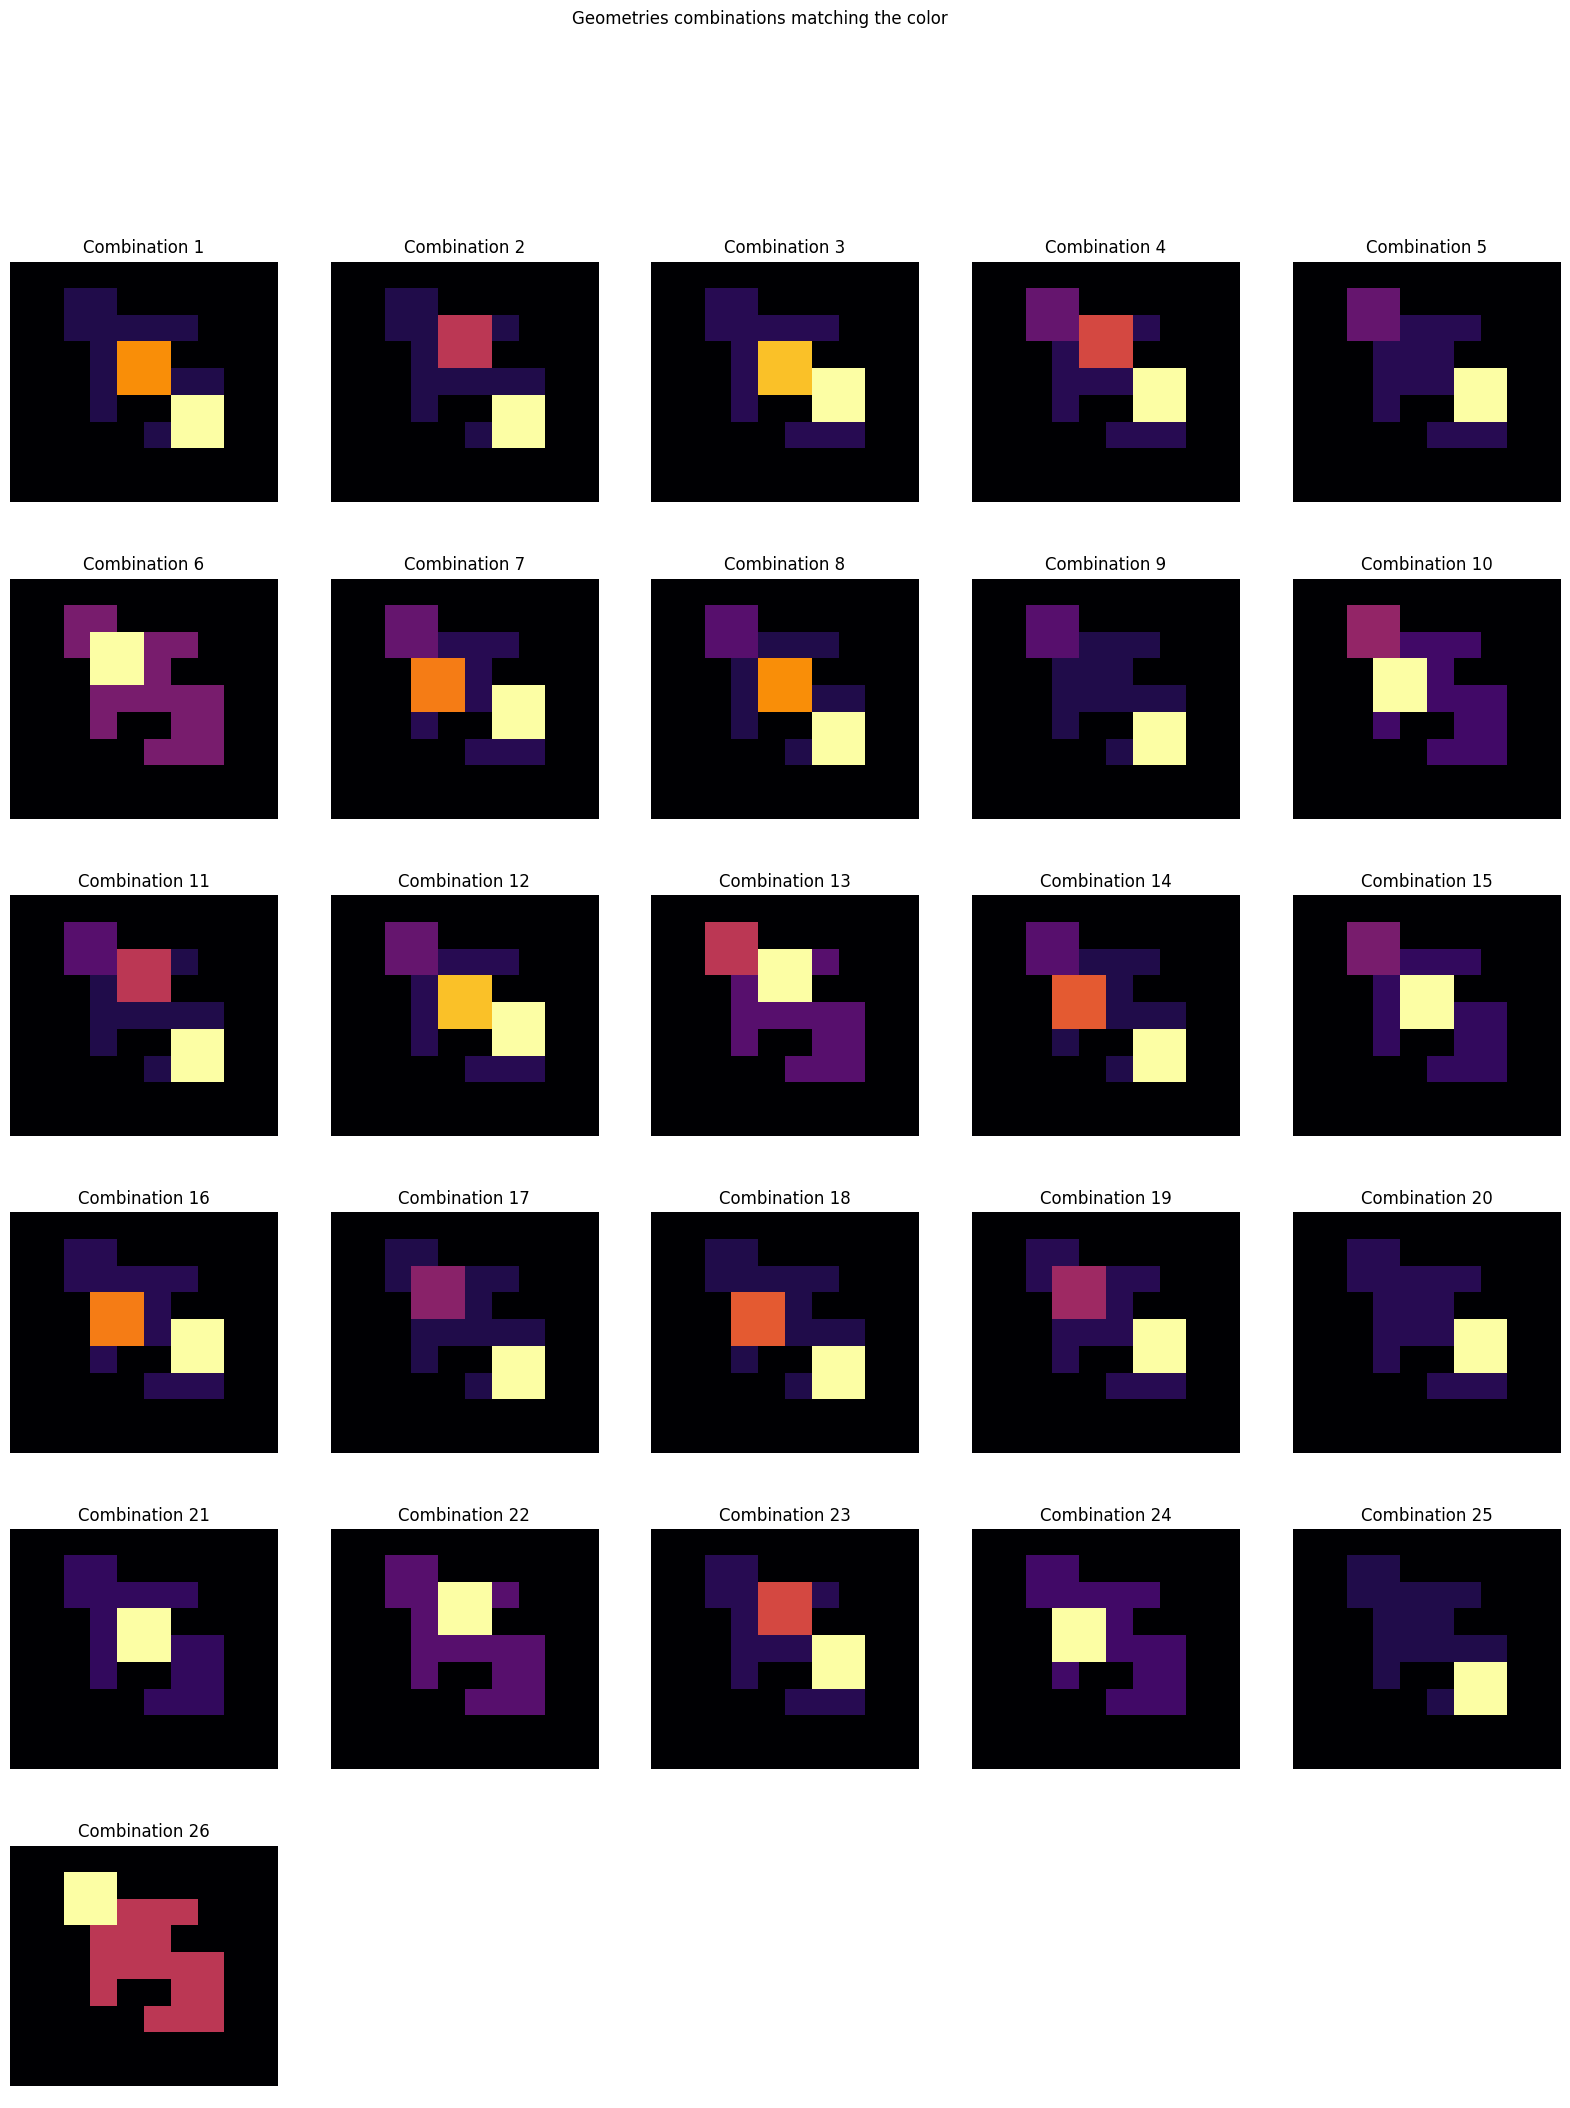

In [174]:
arr = np.array([
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

# plot the array as an image
plt.imshow(arr)
plt.show()

# find all squares of color 1 with side length 2
geometries = select_by_color_and_geometry(arr, 1, 2, 2, display=True)

In [175]:
def select_by_color_and_geometry(array, color, l1, l2, display=False):

    """
    This function selects the elements of the array that are of a certain color and have a certain geometry.
    If more than one selection is possible, both are returned. Both will be kept as a possible transformation.
    The utility function will then have to decide which one to keep. 
    """

    # mask elements of the array
    color_mask = select_by_color(array, color)
    indices_color = np.where(color_mask) # indices of the elements of the array that are of the color we are looking for

    all_geometries = []

    # iterate over the indices of the elements of the array that are of the color we are looking for 
    # to find all matching geometries of the color we are looking for. 
    for i, j in zip(*indices_color):
        
        delta_i = l1
        delta_j = l2

        new_i = i + delta_i
        new_j = j + delta_j

        new_i_in_bounds = new_i >= 0 and new_i < array.shape[0]
        new_j_in_bounds = new_j >= 0 and new_j < array.shape[1]

        if new_i_in_bounds and new_j_in_bounds: # if the new indices are in bounds, we can select the geometry
            geometry = color_mask[i:new_i, j:new_j] # select the geometry in the color mask

            if np.sum(geometry) == l1*l2: # if the geometry is all of the color we are looking for, we can return it
                all_geometries.append((i, j, new_i, new_j)) # return the indices of the geometry

    
    if display:
        # plot the geometries if display is True
        plot_geometries(array, all_geometries)

    def overlap(geometry1, geometry2):
        """
        Check if two geometries overlap.
        """
        i1, j1, new_i1, new_j1 = geometry1
        i2, j2, new_i2, new_j2 = geometry2

        # check if the geometries overlap
        overlap_i = (i1 > i2 and i1 < new_i2) or (new_i1 > i2 and new_i1 < new_i2) or (i2 > i1 and i2 < new_i1) or (new_i2 > i1 and new_i2 < new_i1)
        overlap_j = (j1 > j2 and j1 < new_j2) or (new_j1 > j2 and new_j1 < new_j2) or (j2 > j1 and j2 < new_j1) or (new_j2 > j1 and new_j2 < new_j1)
        
        overlap_i = overlap_i or (i1 == i2 and new_i1 == new_i2)
        overlap_j = overlap_j or (j1 == j2 and new_j1 == new_j2)

        overlap = overlap_i and overlap_j
        return overlap

    geometries_combinations = set() # store all possible combinations of the geometries that do not overlap
    
    # find all possible combinations of the geometries that do not overlap
    for i, geometry1 in enumerate(all_geometries): # iterate over all geometries
        geometry_combination_i = set([i]) # store the indices of the geometries that do not overlap with geometry1
        
        for j, geometry2 in enumerate(all_geometries): # iterate over all geometries again
            overlap_found = False
            for k in geometry_combination_i: # iterate over the indices of the geometries that are already in the combination
                selected_geometry = all_geometries[k] # get the geometry that is already in the combination
                if overlap(geometry2, selected_geometry): # check if the geometry2 overlaps with the selected geometry
                    overlap_found = True # if there is an overlap, we break
                    break
            if not overlap_found: # if there is no overlap, we add the geometry to the combination
                geometry_combination_i.add(j) 
        geometry_combination_i = frozenset(geometry_combination_i) # convert the set to a frozenset to be able to add it to the set of geometries combinations
        geometries_combinations.add(geometry_combination_i) # add the combination to the set of geometries combinations

    geometries_combinations = list(geometries_combinations) # convert the set to a list


    if display:
        # plot the geometries combinations if display is True
        plot_geometry_combinations(array, geometries_combinations, all_geometries)

    return geometries_combinations

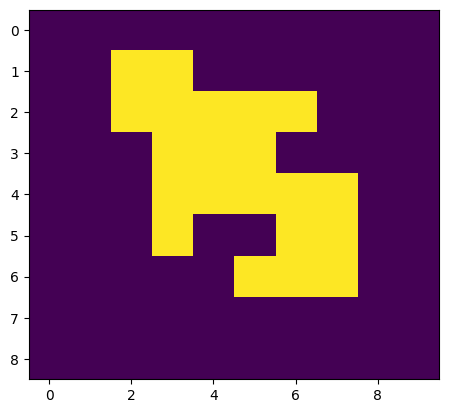

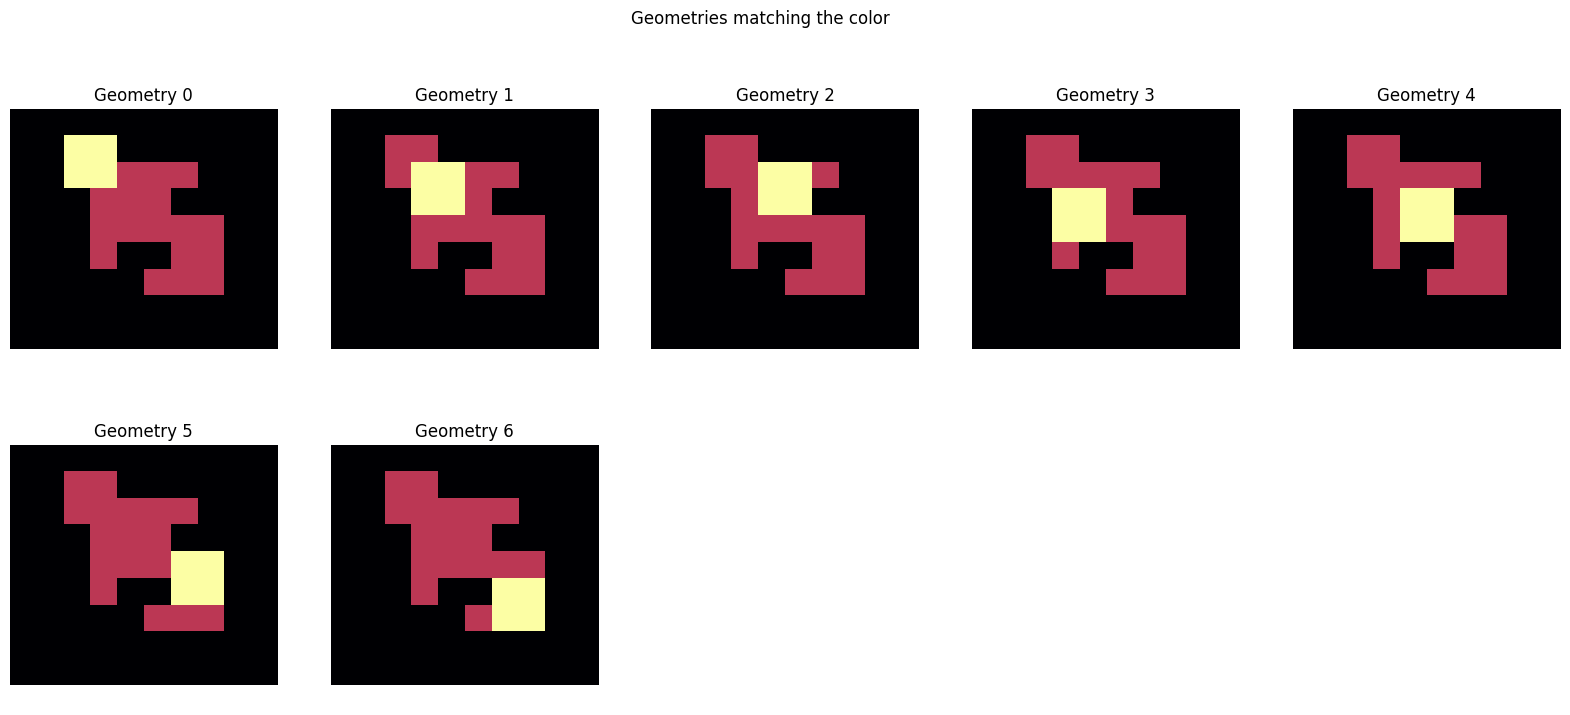

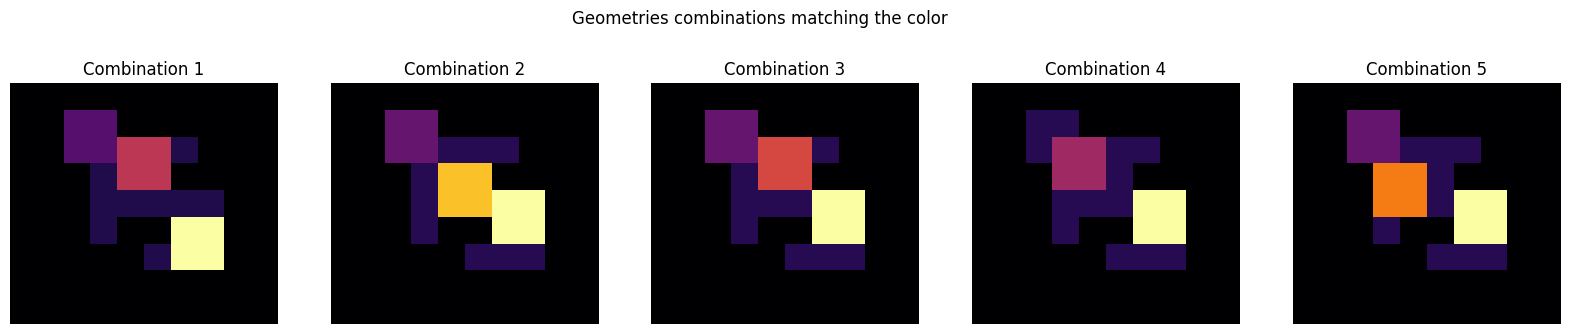

In [176]:
arr = np.array([
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

# plot the array as an image
plt.imshow(arr)
plt.show()

# find all squares of color 1 with side length 2
geometries = select_by_color_and_geometry(arr, 1, 2, 2, display=True)